<h1>Maira Rag Solution</h1>

<h4>SQLAlchemy Code for User Authentication</h4>

In [120]:
from sqlalchemy import create_engine, Column, String
from sqlalchemy.orm import relationship, declarative_base, sessionmaker
from sqlalchemy import select

# Base class for model definitions
Base = declarative_base()

# Define the Users model
class User(Base):
    __tablename__ = 'users'

    user_id = Column(String, primary_key=True)
    username = Column(String, nullable=False, unique=True)
    email = Column(String, nullable=False, unique=True)
    full_name = Column(String, nullable=False)

    # Relationship to UserDataSourceAccess
    user_data_source_access = relationship("UserDataSourceAccess", back_populates="user")

# Define the DataSource model
class DataSource(Base):
    __tablename__ = 'DataSource'

    dataSourceId = Column(String, primary_key=True)
    dataSourceName = Column(String, nullable=False)
    dataSourceDescription = Column(String, nullable=False)

    # Relationship to UserDataSourceAccess
    user_data_source_access = relationship("UserDataSourceAccess", back_populates="data_source")

# Define the UserDataSourceAccess model
class UserDataSourceAccess(Base):
    __tablename__ = 'UserDataSourceAccess'

    userId = Column(String, primary_key=True)
    dataSourceId = Column(String, primary_key=True)

    # Relationship to User
    user = relationship("User", back_populates="user_data_source_access")
    # Relationship to DataSource
    data_source = relationship("DataSource", back_populates="user_data_source_access")


# Setup Database connection
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=db_engine)

# Create the tables in the database
Base.metadata.create_all(bind=engine)

# Function to retrieve user data sources
def get_user_data_sources(db: Session, user_id: str):
    query = (
        select(DataSource.dataSourceId, DataSource.dataSourceName, DataSource.dataSourceDescription)
        .join(UserDataSourceAccess, DataSource.dataSourceId == UserDataSourceAccess.dataSourceId)
        .where(UserDataSourceAccess.userId == user_id)
    )
    result = db.execute(query).fetchall()
    data_sources = [{"dataSourceId": r[0], "dataSourceName": r[1], "dataSourceDescription": r[2]} for r in result]
    return data_sources

# Example function to get data sources for a user
def get_user_data_sources_example(user_id: str):
    db = SessionLocal()
    try:
        data_sources = get_user_data_sources(db, user_id)
        return data_sources
    finally:
        db.close()

ProgrammingError: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Column 'user_id' in table 'users' is of a type that is invalid for use as a key column in an index. (1919) (SQLExecDirectW)")
[SQL: 
CREATE TABLE users (
	user_id VARCHAR(max) NOT NULL, 
	username VARCHAR(max) NOT NULL, 
	email VARCHAR(max) NOT NULL, 
	full_name VARCHAR(max) NOT NULL, 
	PRIMARY KEY (user_id), 
	UNIQUE (username), 
	UNIQUE (email)
)

]
(Background on this error at: https://sqlalche.me/e/20/f405)

<h4>Defining Retrievers</h4>

<h5>Azure Search Vector Store</h5>

In [3]:
%pip install --upgrade --quiet  azure-search-documents
%pip install --upgrade --quiet  azure-identity
%pip install --upgrade --quiet pypdf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [187]:
import os

from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.retrievers import AzureAISearchRetriever

In [188]:
from dotenv import load_dotenv
load_dotenv()

True

In [189]:
# embeddings = AzureOpenAIEmbeddings(
#     model="text-embedding-ada-002"
# )
# index_name: str = "company-reports-analysis"
# vector_store: AzureSearch = AzureSearch(
#     azure_search_endpoint=os.getenv('VECTOR_STORE_ADDRESS'),
#     azure_search_key=os.getenv('VECTOR_STORE_PASSWORD'),
#     index_name=index_name,
#     embedding_function=embeddings.embed_query,
#     additional_search_client_options={"retry_total": 4}
# )
# pdf_files = [
#     "AAPL_Report.pdf",
#     "GOOG_Report.pdf",
#     "MSFT_Report.pdf",
# ]

# # Load PDF documents
# docs = [PyPDFLoader(file).load() for file in pdf_files]
# docs_list = [page for pdf in docs for page in pdf]  # Flatten the list of pages

# # Split documents into chunks
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=500,
#     chunk_overlap=0
# )
# doc_splits = text_splitter.split_documents(docs_list)

# vector_store.add_documents(documents=doc_splits)

In [190]:
vector_store_retriever = AzureAISearchRetriever(
    content_key="content", top_k=3, index_name="company-reports-analysis", service_name=os.getenv('VECTOR_STORE_ADDRESS'), api_key=os.getenv('VECTOR_STORE_PASSWORD')
)

In [193]:
x = vector_store_retriever.invoke("How well do you think AAPL manages its liquidity")

In [194]:
x[0].page_content

"European Commission's claim that Ireland granted state aid to Apple in assessing taxes on earnings from certain local subsidiaries. Apple had $14.1 billion of \ncash at F3Q '23 that was restricted from general use while the dispute is pending . \nRegulations governing consumers' personal data and its use by digital platforms including the EU's General Data Protection Regulation and California Consumer \nPrivacy Act of 2020, reflect heightened regulatory focus on this area. Apple describes data privacy as a fundamental human right. Apple's operating system \nsoftware require software publishers to obtain permission from users to allow tracking of the users or access the device's advertising identifiers. These changes \nhave upended the digital advertising industry's ability to serve targeted, performance ads and increased tensions between industry participants. The confluence \nof new regulations with varying standards in different jurisdictions and the lack of clarity in existing regu

<h5>SQL Agent on Azure SQL DB</h5>

In [28]:
%pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [234]:
import pyodbc
import os
from dotenv import load_dotenv
from langchain.agents import create_sql_agent
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI
from sqlalchemy import create_engine
import urllib
load_dotenv()

True

In [235]:
conn_str = os.environ['CONNECTION_STRING']

db_engine = create_engine(conn_str)

db = SQLDatabase(db_engine, view_support=True, schema="dbo")

# test the connection
print(db.dialect)
print(db.get_usable_table_names())
db.run("select convert(varchar(25), getdate(), 120)")

OperationalError: (pyodbc.OperationalError) ('HYT00', '[HYT00] [Microsoft][ODBC Driver 18 for SQL Server]Login timeout expired (0) (SQLDriverConnect)')
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [236]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)

In [170]:
prefix = "Provide the final answer as Final Answer:. If final answer can be reached return Final Answer: error."
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    prefix=prefix,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    agent_executor_kwargs={
        "handle_parsing_errors": True
    }
)

In [171]:
result = agent_executor.invoke("What is the ESG score for AAPL")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: ""clientData, esgData, instrumentData, marketData, traceData, tradeDataI should query the schema of the esgData table to see if it contains the ESG score for AAPL.
Action: sql_db_schema
Action Input: esgData
CREATE TABLE dbo.[esgData] (
	[esmId] VARCHAR(20) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	[overallScore] INTEGER NULL, 
	environmental VARCHAR(30) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	social VARCHAR(30) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	governance VARCHAR(30) COLLATE SQL_Latin1_General_CP1_CI_AS NULL, 
	comment VARCHAR(5000) COLLATE SQL_Latin1_General_CP1_CI_AS NULL
)

/*
3 rows from esgData table:
esmId	overallScore	environmental	social	governance	comment
34556	28	AMBER	GREEN	GREEN	Likely to run into Regulatory challenges in EU
*/I should use sql_db_query to retrieve the ESG score for AAPL from the esgData table.
Action: sql_db_query
Action Input: SELECT overallScore FROM 

In [173]:
Docuresult["output"]

'The ESG score for AAPL is 28.'

<h5>Websearch Toolkit Tavily</h5>

In [42]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

<h4>Decomposition and Routing</h4>

In [83]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from typing import List, Optional, Literal

In [104]:
class SubQuestion(BaseModel):
    """Defines a subquestion and its datasource."""

    subquestion: str = Field(..., description="The specific subquestion to be answered.")
    datasource: Optional[Literal["vectorstore", "web_search", "sql_db", None]] = Field(
        None, description="The datasource to be used for this subquestion. Given a subquestion choose to route it to web search, vectorstore or sql database."
    )


class RouteQuery(BaseModel):
    """Routes a main question to relevant subquestions and datasources."""

    subquestions: List[SubQuestion] = Field(
        ..., description="A list of subquestions with associated datasources."
    )

In [110]:
system_prompt = """
You are an expert at breaking down complex questions into subquestions and routing each subquestion to the correct datasource.
Given a main question, split it into relevant subquestions and assign the most appropriate datasource to each.
Your response must be a list of JSON objects, with each object containing:
- "subquestion": The specific subquestion text.
- "datasource": One of ["vectorstore", "web_search", "sql_db", null].
Set datasource to null if for that subquestion we don't require any datasource
You must always return valid JSON fenced by a markdown code block. Do not return code or any additional text as follows:
{{
  "subquestions": [
        {{
            "subquestion": "What is the Book exposure to Tech Sector for trader Tirth?",
            "datasource": "sql_db"
        }}
    ]
}}
"""

In [111]:
# Initialize the LLM with function call for structured output
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)
structured_llm_router = llm.with_structured_output(RouteQuery)

datasources = """Following are the details of the available data sources:
Table: clientData
Datasource: sql_db
Description: Contains client information, including client names and whether they are restricted (e.g., restricted status as "YES" or "NO"). Useful for managing and identifying client restrictions related to trades or compliance. 
Columns:
    - srno: INTEGER
    - client: VARCHAR(30)
    - restricted: VARCHAR(10)

Table: esgData
Datasource: sql_db
Description: Contains ESG ratings for instruments, identified by esmId. It includes an overall ESG score, individual ratings for environmental, social, and governance factors, and any comments. Useful for sustainability analysis and evaluating instruments' regulatory risks or environmental impacts.
Columns:
    - esmId: VARCHAR(20)
    - overallScore: INTEGER
    - environmental: VARCHAR(30)
    - social: VARCHAR(30)
    - governance: VARCHAR(30)
    - comment: VARCHAR(5000)
    
Table: instrumentData
Datasource: sql_db
Description: Contains static information about financial instruments, such as unique identifiers (esmId, isin), ticker, interest (coupon), maturity date, sector, rating, type of product, country, and ESG score. This table provides detailed characteristics of each instrument.
Columns:
    - esmId: VARCHAR(20)
    - isin: VARCHAR(30)
    - ticker: VARCHAR(20)
    - coupon: FLOAT
    - maturity: DATE
    - sector: VARCHAR(30)
    - rating: VARCHAR(10)
    - product: VARCHAR(30)
    - country: VARCHAR(20)
    - esgScore: INTEGER

Table: marketData
Datasource: sql_db
Description: Holds historical market pricing information for each instrument identified by isin. It includes the coupon, maturity, market price, date, and time, useful for tracking price fluctuations and market trends of instruments over time.  
Columns:
    - isin: VARCHAR(30)
    - ticker: VARCHAR(20)
    - coupon: FLOAT
    - maturity: DATE
    - marketPrice: FLOAT
    - date: DATE
    - time: TIME

Table: traceData
Datasource: sql_db
Description: Contains transaction trace data for each instrument identified by isin. Includes coupon, maturity, quote, notional amount, date, and time of the trace, which is useful for tracking trade volumes and quote changes over time.
Columns:
    - isin: VARCHAR(30) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - ticker: VARCHAR(20) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - coupon: FLOAT
    - maturity: DATE
    - quote: INTEGER
    - notional: INTEGER
    - date: DATE
    - time: TIME

Table: tradeData
Datasource: sql_db
Description: Stores trade transactions associated with each instrument (esmId), including trade ID, client name, notional amount, quote, trade price, trader, book, trade position, side (buy/sell), and trade date. Useful for analyzing trade history, volumes, and specific client or trader activities.
Columns:
    - srNo: INTEGER
    - esmId: VARCHAR(20) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - tradeId: VARCHAR(20) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - client: VARCHAR(20) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - notional: INTEGER
    - quote: INTEGER
    - price: FLOAT
    - traderName: VARCHAR(30) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - book: VARCHAR(20) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - position: INTEGER
    - barclaysSide: VARCHAR(10) COLLATE "SQL_Latin1_General_CP1_CI_AS"
    - tradeDate: DATE

Index Name: company-reports-analysis
Datasource: vectorstore
Description: This vector store contains embedded Moody's reports on companies like Apple (AAPL), Microsoft (MSFT), and Google (GOOG), offering insights into financial performance, credit ratings, market trends, and risk assessments. It enables semantic search for questions on company fundamentals, industry comparisons, and creditworthiness.

Datasource: web_search
Description: To get current and real-time online information, use the web_search agent. This agent allows access to up-to-date details on topics such as live market data, recent news, and the latest industry insights, expanding responses beyond the data stored here. 
"""

# Create the prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "\n {datasource} \n \n Break down the following complex question into subquestions and route each subquestion to the correct datasource"),
    ]
)

# Set up the chain
question_router = route_prompt | structured_llm_router

# Sample invocation
response = question_router.invoke(
    {"question": "What is the Book exposure to Tech Sector for trader Tirth", "datasource": datasources}
)

print(response)

OutputParserException: Function RouteQuery arguments:

const RouteQuery: functions.RouteQuery = ({ subquestions }) => {
  return {
    subquestions: subquestions.map(({ subquestion }) => {
      if (subquestion.includes("Book exposure to Tech Sector")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("ESG rating for instrument")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("Static information about financial instruments")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("Historical market pricing information")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("Transaction trace data")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("Trade transactions associated with each instrument")) {
        return {
          subquestion,
          datasource: "sql_db",
        };
      }
      if (subquestion.includes("Moody's reports on companies")) {
        return {
          subquestion,
          datasource: "vectorstore",
        };
      }
      if (subquestion.includes("Online information")) {
        return {
          subquestion,
          datasource: "web_search",
        };
      }
      return {
        subquestion,
        datasource: null,
      };
    }),
  };
};

are not valid JSON. Received JSONDecodeError Expecting value: line 1 column 1 (char 0)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE

In [121]:
data = {
  "subquestions": [
    {
      "subquestion": "What is the Book exposure to the Tech sector for trader Tirth?",
      "datasource": "sql_db"
    },
    {
      "subquestion": "What trades in the Tech sector are associated with trader Tirth, and what are the respective notional values?",
      "datasource": "sql_db"
    }
  ]
}

In [122]:
route_query = RouteQuery(**data)

# Output the instance to verify
print(route_query)

subquestions=[SubQuestion(subquestion='What is the Book exposure to the Tech sector for trader Tirth?', datasource='sql_db'), SubQuestion(subquestion='What trades in the Tech sector are associated with trader Tirth, and what are the respective notional values?', datasource='sql_db')]


<h4>Relevance Evaluator</h4>

In [89]:
# Data model
class GradeContext(BaseModel):
    """Binary score for relevance check on retrieved contexts."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)
structured_llm_grader = llm.with_structured_output(GradeContext)

# Prompt
system = """You are a grader assessing relevance of a retrieved context to a user question. \n 
    If the context contains keyword(s), semantic meaning, background information, or answer related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a score 'yes' or 'no' score to indicate whether the context is relevant to the question.\n
    You must always return valid JSON fenced by a markdown code block. Do not return any additional text, space, or lines.
    Enclose the property name in double quotes.
"""


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved context: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "Google revenue"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

OutputParserException: Function GradeContext arguments:

const gradeContext: functions.GradeContext = ({}) => {
  const document = `Rating History
  5 Year Rating History for 02079KAC1
  Aaa
  Aa
  A
  Baa
  Ba
  B
  Caa
  Ca
  C
  D
  Aa2
  Moody's Rating Outlook
  Stable
  2020 2021 2022 2023 2024
  Credit Challenges
  - Material legal and regulatory risks 
  - Cyclicality of the advertising market.  In 2023, advertising revenue represented around 77.4% of total revenue 
  - Highly competitive industry 
  - Threat from disruptive technologies 
  Rating Outlook
  The stable outlook reflects our expectations that Google Search will continue to maintain a leading position in search, defend its very strong market position in 
  digital advertising, and that Alphabet will remain committed to a very conservative financial policy with exceptional liquidity and very low leverage.
  Factors that Could Lead to an Upgrade
  - The company maintains very conservative financial policies that are already consistent with a higher credit rating; and 
  - Management can navigate legal and regulatory risks such that its business models and diversity are not impaired 
  Factors that Could Lead to an Downgrade
  - The company's core search business deteriorates and results in a material and sustained erosion in its market share position, profitability or free cash flow; or 
  - Management adopts more aggressive financial policies that materially weaken the company's very strong liquidity and credit metrics 
  Detailed credit considerations
  Strong operating fundamentals support long term growth 
  Alphabet's business model is largely dependent on global advertising trends and in particular digital advertising spend. In 2024, we estimate that 71% of global 
  advertising dollars will be spent online, compared to 69% in 2023 and will approach 75% in the next few years. We believe the structural shift to online from 
  traditional media will persist and will help maintain higher growth rates for digital advertisers. For 2024 and 2025, we project digital advertising will grow at around 
  12% and 10%, respectively compared to 9% growth for the overall advertising industry this year, and 5% next year. 
  For 2024 and 2025, we project Alphabet will grow total revenue by 12% and 10%, respectively . Alphabet's total revenue consists of three major segments: (i) 
  Google Services (~89% of Alphabet's revenue), which we project will grow by 10% and 8%, (ii) Google Cloud (~11%), which we project will grow 25% per annum`;
  
  const keywords = ['Google', 'revenue'];
  const semanticMeaning = ['Alphabet will remain committed to a very conservative financial policy with exceptional liquidity and very low leverage', 'Alphabet will grow total revenue by 12% and 10%, respectively', 'Google Services (~89% of Alphabet\'s revenue), which we project will grow by 10% and 8%'];
  const backgroundInfo = ['Alphabet\'s business model is largely dependent on global advertising trends and in particular digital advertising spend.'];

  let score = 'no';

  if (keywords.some(keyword => document.includes(keyword)) && semanticMeaning.every(meaning => document.includes(meaning)) && backgroundInfo.some(info => document.includes(info))) {
    score = 'yes';
  }

  return { binary_score: score };
}
gradeContext({});

are not valid JSON. Received JSONDecodeError Expecting value: line 1 column 1 (char 0)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE

<h4>Generate answers to subquestions</h4>

In [95]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

system_prompt = """You are an expert assistant for traders and sales professionals at an investment bank. Use previous question-answer pairs and provided context to give concise, accurate responses that aid in trade decisions, market analysis, risk assessment, and client interactions."""

# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", template),
    ]
)

llm = AzureChatOpenAI(
    azure_deployment="gpt-4",
    api_version="2024-02-01",
    temperature=0
)
q_a_pairs = ""
data = [  
    {  
        "subquestion": "What are the trades executed by trader Tirth?",  
        "datasource": "sql_db",
        "context": "Trade ID 9203 with client Blackrock for a notional value of 20,000 and a price of 102. Trade ID 9204 with client PIMCO for a notional value of 20,000 and a price of 89. Trade ID 9205 with client Blackrock for a notional value of 15,000 and a price of 98."
    },  
    {  
        "subquestion": "What are the financial instruments associated with these trades?",  
        "datasource": "sql_db",
        "context": "AAPL (ISIN: US2023445), a Technology sector instrument with a coupon of 2.0%, maturing on 2028-12-12, rated AA, and classified as High Grade. IBM (ISIN: US202349), a Technology sector instrument with a coupon of 4.89%, maturing on 2028-12-01, rated BB, and classified as High Grade. RETAIL (ISIN: US202339), a Retail sector instrument with a coupon of 2.0%, maturing on 2028-12-01, rated AAA, and classified as High Yield."
    },  
    {  
        "subquestion": "Which of these financial instruments belong to the Tech Sector?",  
        "datasource": "sql_db",
        "context": "AAPL (ISIN: US2023445) and IBM (ISIN: US202349) are the financial instruments associated with trader Tirth's trades that belong to the Technology sector."
    },  
    {  
        "subquestion": "What is the total notional amount of these Tech Sector trades?",  
        "datasource": "sql_db",
        "context": "The total notional amount of Tirth’s trades in the Technology sector is 40,000 (20,000 for AAPL + 20,000 for IBM)."
    }  
]  
for d in data:
    rag_chain = (
    {"context": itemgetter("context"), 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question": d["subquestion"], "context": d["context"], "q_a_pairs":q_a_pairs})
    print(answer)
    q_a_pair = format_qa_pair(d["subquestion"],answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair


Trader Tirth executed the following trades:

1. Trade ID 9203 with client Blackrock for a notional value of 20,000 and a price of 102.
2. Trade ID 9204 with client PIMCO for a notional value of 20,000 and a price of 89.
3. Trade ID 9205 with client Blackrock for a notional value of 15,000 and a price of 98.


RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 10 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}

In [96]:
q_a_pairs

'\n---\nQuestion: What are the trades executed by trader Tirth?\nAnswer: Trader Tirth executed the following trades:\n\n1. Trade ID 9203 with client Blackrock for a notional value of 20,000 and a price of 102.\n2. Trade ID 9204 with client PIMCO for a notional value of 20,000 and a price of 89.\n3. Trade ID 9205 with client Blackrock for a notional value of 15,000 and a price of 98.'

<h4>Generate answer to main question</h4>

In [98]:
q_a_pairs = """
Q1: What are the trades executed by trader Tirth?
A1: 
- Trade ID 9203 with client Blackrock for a notional value of 20,000 and a price of 102.
- Trade ID 9204 with client PIMCO for a notional value of 20,000 and a price of 89.
- Trade ID 9205 with client Blackrock for a notional value of 15,000 and a price of 98.

Q2: What are the financial instruments associated with these trades?
A2: 
- AAPL (ISIN: US2023445), a Technology sector instrument with a coupon of 2.0%, maturing on 2028-12-12, rated AA, and classified as High Grade.
- IBM (ISIN: US202349), a Technology sector instrument with a coupon of 4.89%, maturing on 2028-12-01, rated BB, and classified as High Grade.
- RETAIL (ISIN: US202339), a Retail sector instrument with a coupon of 2.0%, maturing on 2028-12-01, rated AAA, and classified as High Yield.

Q3: Which of these financial instruments belong to the Tech Sector?
A3: 
- AAPL (ISIN: US2023445) and IBM (ISIN: US202349) are the financial instruments associated with trader Tirth's trades that belong to the Technology sector.

Q4: What is the total notional amount of these Tech Sector trades?
A4: The total notional amount of Tirth’s trades in the Technology sector is 40,000 (20,000 for AAPL + 20,000 for IBM).
"""


In [100]:
system_prompt = """You are an expert assistant for traders and sales professionals at an investment bank. Answer each main question by analyzing relevant subquestion-answer pairs, providing accurate, context-aware responses to support trade decisions, market analysis, risk assessment, and client interactions.
Keep answers concise, professional, and rooted in industry practices and regulatory standards."""

template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Use the above background question + answer pairs to answer the question: \n {question}
"""

generate_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", template),
    ]
)
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)

question_generate = generate_prompt | llm
question_generate.invoke({"question": "What is the Book exposure in USD taking into account notional amount and price to Tech Sector for trader Tirth", "q_a_pairs": q_a_pairs})

AIMessage(content="The book exposure in USD taking into account notional amount and price to the Tech Sector for trader Tirth is $3,620,000. This is calculated by multiplying the total notional amount of Tirth's trades in the Technology sector (40,000) by the weighted average price of the trades [(20,000*102 + 20,000*89)/(20,000+20,000) = 95.5] and then converting to USD (40,000*95.5 = $3,820,000).", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 523, 'total_tokens': 633, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False},

In [101]:
generation = "The book exposure in USD taking into account notional amount and price to the Tech Sector for trader Tirth is $3,620,000. This is calculated by multiplying the total notional amount of Tirth's trades in the Technology sector (40,000) by the weighted average price of the trades [(20,000*102 + 20,000*89)/(20,000+20,000) = 95.5] and then converting to USD (40,000*95.5 = $3,820,000)."

<h4>Hallucination Grader</h4>

In [102]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.\n 
     You must always return valid JSON fenced by a markdown code block. Do not return any additional text, space, or lines.
     Enclose the property name in double quotes.
     """
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {q_a_pairs} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"q_a_pairs": q_a_pairs, "generation": generation})

OutputParserException: Function GradeHallucinations arguments:

{
  binary_score: "yes"
}


are not valid JSON. Received JSONDecodeError Expecting property name enclosed in double quotes: line 2 column 3 (char 4)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE

<h4>Answer Grader</h4>

In [103]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = AzureChatOpenAI(
    azure_deployment="gpt-4",
    api_version="2024-02-01",
    temperature=0
)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.\n
     You must always return valid JSON fenced by a markdown code block. Do not return any additional text, space, or lines. 
     Enclose the property name in double quotes.
     """
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": "What is the Book exposure in USD taking into account notional amount and price to Tech Sector for trader Tirth", "generation": generation})

GradeAnswer(binary_score='yes')

<h4>Query Re-writer</h4>

In [131]:
### Question Re-writer

# LLM
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore, sql, or web search retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question to a better version that is optimized for {datasource} retrieval.",
        ),
    ]
)
question = "What is the Book exposure in USD taking into account notional amount and price to Tech Sector for trader Tirth"
datasource = "sql"
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question, "datasource": datasource})

"What is the total exposure in USD for trader Tirth's book in the Tech Sector, considering the notional amount and price?"

<h4>Generate Error Response</h4>

In [227]:
# LLM
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",
    api_version="2024-02-01",
    temperature=0
)

# Prompt
system = """You are a helpful assistant designed to charmingly let user know that the users question couldn't be answered can they try rephrasing it."""
error_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "I can't help you with that, can you please rephrase your question",
        ),
    ]
)
error_response = error_prompt | llm | StrOutputParser()
error_response.invoke({})

"I'm sorry, but I'm not able to provide an answer to your question. Could you please try rephrasing it or providing more context so that I can better understand what you're looking for? I'm here to assist you in any way I can."

<h4>Graph Building</h4>

In [214]:
from typing import TypedDict, List, Dict, Annotated
from langchain.schema import Document
from langgraph.types import Send

class SubquestionData(TypedDict):
    """Represents the data for each subquestion, including context and answer."""
    context: str
    answer: List[str]
    datasource: str

class Retriever(TypedDict):
    subq: str
    datasource: str

class GraphState(TypedDict):
    question: str
    userId: str
    dataSourceDescription: str
    subquestion: Dict[str, SubquestionData]
    subanswers: Annotated[dict, operator.or_]
    generation: str
    q_a_pairs: str
    iteration: int

In [223]:
def db_authentication_data_description(state: GraphState):
    user_id = state["userId"]
    data_sources = get_user_data_sources_example(user_id)
    #format datasourceDescription
    state["datasourceDescription"] = formatted_dataSourceDescription
    return state

def decomposition_routing(state: GraphState):
    question = state["question"]
    state["iteration"] += 1
    data_sources_description = state["datasourceDescription"]
    response = question_router.invoke(
    {"question": question, "datasource": data_sources_description}
    )
    subquestion_dict = {}
    for subq in route_query.subquestions:
        subquestion_dict[subq.subquestion] = {
            "datasource": subq.datasource
        }
    state["subquestion"] = subquestion_dict
    return state

def retriever(state: Retriever):
    iterations = 0
    isRelevant = False
    print(state)
    subquestion = state["subq"]
    datasource = state["datasource"]
    subans = {}
    while isRelevant==False and iterations<=2:
        if datasource == "sql_db":
            result = agent_executor.invoke(subquestion)
            result = [Document(page_content=result["output"])]
        elif datasource == "vectorstore":
            result = vector_store_retriever.invoke(subquestion) 
        elif datasource == "web_search":
            docs = web_search_tool.invoke({"query": question})
            web_results = "\n".join([d["content"] for d in docs])
            result = [Document(page_content=web_results)]
        else:
            subans[subquestion] = ""
            break
        for r in result:
            score = retrieval_grader.invoke({"question": question, "document": r.page_content})
            grade = score.binary_score
            if grade == "yes":
                subans[question] = r.page_content
            else:
                continue
        if len(subans) > 0:
            isRelevant = True
        else:
            state = transform_query(state)
        iterations += 1
    return {"subanswers": subans}

def continue_to_retrieve(state: GraphState):
    return [Send("retriever", {"subq": k, "datasource":v["datasource"]}) for k,v in state["subquestion"].items()]

def sub_generator(state: GraphState):
    subquestion = state["subquestion"]
    state["iteration"] += 1
    for k,v in subquestion.items():
        rag_chain = (
        {"context": itemgetter("context"), 
         "question": itemgetter("question"),
         "q_a_pairs": itemgetter("q_a_pairs")} 
        | decomposition_prompt
        | llm
        | StrOutputParser())

        answer = rag_chain.invoke({"question": k, "context": k["context"], "q_a_pairs":q_a_pairs})
        state["subquestion"][k]["answer"] = answer
        q_a_pair = format_qa_pair(k,answer)
        q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair
    return state

def generator(state: GraphState):
    question = state["question"]
    q_a_pairs = state["q_a_pairs"]
    answer = question_generate.invoke({"question": question, "q_a_pairs": q_a_pairs})
    state["generation"] = answer
    return state

def transform_query(state: GraphState):
    question = state["subq"]
    datasource = state["datasource"]
    better_question = question_rewriter.invoke({"question": question, "datasource": datasource})
    state["subq"] = better_question
    return state

def error_response(state: GraphState):
    response = error_response.invoke({})
    state["generator"] = response
    return state

In [216]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the context and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    q_a_pairs = state["q_a_pairs"]
    generation = state["generation"]
    iteration = state["iteration"]

    score = hallucination_grader.invoke(
        {"q_a_pairs": q_a_pairs, "generation": generation}
    )
    grade = score.binary_score

    if iteration > 3:
        return "unable to find answer"
    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [232]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
workflow.add_node("db_authentication_data_description", db_authentication_data_description)
workflow.add_node("decomposition_routing", decomposition_routing)
workflow.add_node("retriever", retriever)
workflow.add_node("sub_generator", sub_generator)
workflow.add_node("generator", generator)
workflow.add_node("error_response", transform_query)


workflow.add_edge(START, "db_authentication_data_description")
workflow.add_edge("db_authentication_data_description", "decomposition_routing")
workflow.add_conditional_edges("decomposition_routing", continue_to_retrieve, ["retriever"])
workflow.add_edge("retriever", "sub_generator")
workflow.add_edge("sub_generator", "generator")
workflow.add_conditional_edges(
    "generator",
    grade_generation_v_documents_and_question,
    {
        "not supported": "sub_generator",
        "useful": END,
        "not useful": "decomposition_routing",
        "unable to find answer": "error_response"
    },
)
workflow.add_edge("error_response", END)
app = workflow.compile()

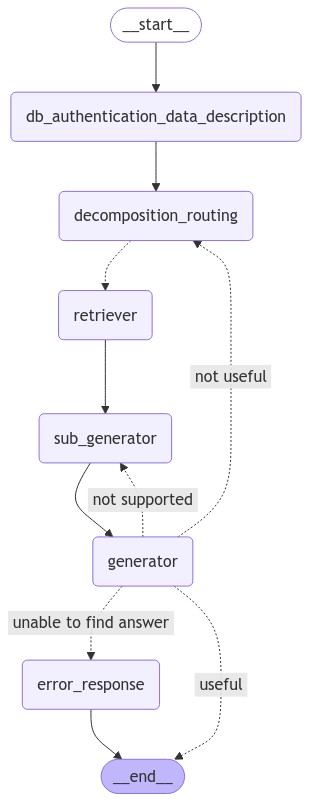

In [233]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [125]:
subquestion_dict = {}
for subq in route_query.subquestions:
    subquestion_dict[subq.subquestion] = {
        "datasource": subq.datasource
    }

In [126]:
subquestion_dict

{'What is the Book exposure to the Tech sector for trader Tirth?': {'datasource': 'sql_db'},
 'What trades in the Tech sector are associated with trader Tirth, and what are the respective notional values?': {'datasource': 'sql_db'}}

In [129]:
for k,v in subquestion_dict.items():
    print(k)
    print(v["datasource"])

What is the Book exposure to the Tech sector for trader Tirth?
sql_db
What trades in the Tech sector are associated with trader Tirth, and what are the respective notional values?
sql_db


In [132]:
from functools import reduce
import operator

# List of dictionaries representing the results from each "generate_joke" node
# Each dictionary maps a subject to a generated joke
joke_results = [
    {"subject1": "Why did the chicken join a band? Because it had the drumsticks!"},
    {"subject2": "What do you call fake spaghetti? An impasta!"},
    {"subject3": "How do you organize a space party? You planet!"},
]

# Using reduce to combine all dictionaries into one with operator.or_
combined_jokes = reduce(operator.or_, joke_results)

print("Combined Jokes Dictionary:")
print(combined_jokes)


Combined Jokes Dictionary:
{'subject1': 'Why did the chicken join a band? Because it had the drumsticks!', 'subject2': 'What do you call fake spaghetti? An impasta!', 'subject3': 'How do you organize a space party? You planet!'}


In [161]:
docs = web_search_tool.invoke({"query": "Which movie grossed highest this year"})
web_results = "\n".join([d["content"] for d in docs])
result = [Document(page_content=web_results)]

In [162]:
result

[Document(metadata={}, page_content='"Top Gun: Maverick" soared past $400 million at the domestic box office, making it the highest-grossing movie of the year in the U.S. With $401.8 million in North American ticket sales,\nTo date, the Paramount Pictures movie has grossed $520.8 million at the domestic box office and stands as the highest-grossing movie of the year in North America. "Top Gun: Maverick" still had\nPrior to this weekend, the sequel to the 1986 action flick "Top Gun" was already the highest-grossing movie of the year at the domestic box office with $521 million. Now in its fifth weekend\nSpielberg has the record, directing four of the yearly highest-grossing films: Raiders of the Lost Ark (1981), E.T. the Extra-Terrestrial (1982), Jurassic Park (1993), and Saving Private Ryan (1998). Lucas has directed three such films, all of which are part of the Star Wars franchise, which he created: the original Star Wars (1977), and two of\nHere are the top 10 highest-grossing movie

In [175]:
Document(page_content=result["output"])

Document(metadata={}, page_content='The ESG score for AAPL is 28.')

In [180]:
a = {}

In [177]:
a["xyx"] = result["output"]

In [181]:
len(a)

0

In [213]:
xyz = [
        {"subq": "Should I buy AAPL", "datasource":None}]
for d in xyz:
    ans = retriever(d)
    print(ans)

{'subq': 'Should I buy AAPL', 'datasource': None}
{'subanswers': {'Should I buy AAPL': ''}}


In [224]:
state = transform_query({"subq": "What is the ESG score for AAPL", "datasource": "sql_db"})

In [225]:
state

{'subq': 'What is the Environmental, Social, and Governance (ESG) score of Apple Inc. in the SQL database?',
 'datasource': 'sql_db'}